In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Install Libraries**

In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

## **Import Libraries**

In [4]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
# from keras import ops
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout,GlobalAveragePooling2D
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

2024-04-08 07:29:26.736690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 07:29:26.736748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 07:29:26.738125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Library Versions** 

In [5]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.4
KerasCV: 0.8.2



## **Configurations**

In [6]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "densenet121_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

#### **Sets value for random seed to produce similar result in each run.**

In [7]:
keras.utils.set_random_seed(CFG.seed)

## **Dataset Paths**

In [8]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [9]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   

   grda_vote  other_vote                                           eeg_path  \
0          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
1          0           0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   
1  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path class_name  class_label  
0  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0  
1  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0

spectrogram_id      eeg_id  patient_id  \
0          853520  3911565283        6885   

                                            eeg_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path  
0  /tmp/dataset/hms-hbac/test_spectrograms/853520...

In [10]:
df.isnull().sum()

eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
expert_consensus                    0
seizure_vote                        0
lpd_vote                            0
gpd_vote                            0
lrda_vote                           0
grda_vote                           0
other_vote                          0
eeg_path                            0
spec_path                           0
spec2_path                          0
class_name                          0
class_label                         0
dtype: int64

In [11]:
df

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0       1628180742           0                       0.0          353733   
1       1628180742           1                       6.0          353733   
2       1628180742           2                       8.0          353733   
3       1628180742           3                      18.0          353733   
4       1628180742           4                      24.0          353733   
...            ...         ...                       ...             ...   
106795   351917269           6                      12.0      2147388374   
106796   351917269           7                      14.0      2147388374   
106797   351917269           8                      16.0      2147388374   
106798   351917269           9                      18.0      2147388374   
106799   351917269          10                      20.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                        0                               0.0   127492639   
1                        1                               6.0  3887563113   
2                        2                               8.0  1142670488   
3                        3                              18.0  2718991173   
4                        4                              24.0  3080632009   
...                    ...                               ...         ...   
106795                   6                              12.0  4195677307   
106796                   7                              14.0   290896675   
106797                   8                              16.0   461435451   
106798                   9                              18.0  3786213131   
106799                  10                              20.0  3642716176   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
0            42516          Seizure             3         0         0   
1            42516          Seizure             3         0         0   
2            42516          Seizure             3         0         0   
3            42516          Seizure             3         0         0   
4            42516          Seizure             3         0         0   
...            ...              ...           ...       ...       ...   
106795       10351             LRDA             0         0         0   
106796       10351             LRDA             0         0         0   
106797       10351             LRDA             0         0         0   
106798       10351             LRDA             0         0         0   
106799       10351             LRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  \
0               0          0           0   
1               0          0           0   
2               0          0           0   
3               0          0           0   
4               0          0           0   
...           ...        ...         ...   
106795          3          0           0   
106796          3          0           0   
106797          3          0           0   
106798          3          0           0   
106799          3          0           0   

                                                 eeg_path  \
0       /kaggle/input/hms-harmful-brain-activity-class...   
1       /kaggle/input/hms-harmful-brain-activity-class...   
2       /kaggle/input/hms-harmful-brain-activity-class...   
3       /kaggle/input/hms-harmful-brain-activity-class...   
4       /kaggle/input/hms-harmful-brain-activity-class...   
...                                                   ...   
106795  /kaggle/input/hms-harmful-brain-activity-class...   
106796  /kaggle/input/hms-harmful-brain-activity-class...   
106797  /kaggle/input/hms-harmful-brain-activity-class...   
106798  /kaggle/input/hms-harmful-brain-activity-class...   
106799  /kaggle/input/hms-harmful-brain-activity-class...   

                                               

In [12]:
test_df

spectrogram_id      eeg_id  patient_id  \
0          853520  3911565283        6885   

                                            eeg_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path  
0  /tmp/dataset/hms-hbac/test_spectrograms/853520...

## **Coverting dataset datatype(.parquet to .npy)**

In [13]:
# Define a function to process a single eeg_id

def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids,total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## **EDA using visual graphs**

In [14]:
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Shape of the dataset
df.shape

(106800, 20)

In [16]:
df.describe()

eeg_id     eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
count  1.068000e+05  106800.000000             106800.000000    1.068000e+05   
mean   2.104387e+09      26.286189                118.817228    1.067262e+09   
std    1.233371e+09      69.757658                314.557803    6.291475e+08   
min    5.686570e+05       0.000000                  0.000000    3.537330e+05   
25%    1.026896e+09       1.000000                  6.000000    5.238626e+08   
50%    2.071326e+09       5.000000                 26.000000    1.057904e+09   
75%    3.172787e+09      16.000000                 82.000000    1.623195e+09   
max    4.294958e+09     742.000000               3372.000000    2.147388e+09   

       spectrogram_sub_id  spectrogram_label_offset_seconds      label_id  \
count       106800.000000                     106800.000000  1.068000e+05   
mean            43.733596                        520.431404  2.141415e+09   
std            104.292116                       1449.759868  1.241670e+09   
min              0.000000                          0.000000  3.380000e+02   
25%              2.000000                         12.000000  1.067419e+09   
50%              8.000000                         62.000000  2.138332e+09   
75%             29.000000                        394.000000  3.217816e+09   
max           1021.000000                      17632.000000  4.294934e+09   

          patient_id   seizure_vote       lpd_vote       gpd_vote  \
count  106800.000000  106800.000000  106800.000000  106800.000000   
mean    32304.428493       0.878024       1.138783       1.264925   
std     18538.196252       1.538873       2.818845       3.131889   
min        56.000000       0.000000       0.000000       0.000000   
25%     16707.000000       0.000000       0.000000       0.000000   
50%     32068.000000       0.000000       0.000000       0.000000   
75%     48036.000000       1.000000       1.000000       0.000000   
max     65494.000000      19.000000      18.000000      16.000000   

           lrda_vote      grda_vote     other_vote    class_label  
count  106800.000000  106800.000000  106800.000000  106800.000000  
mean        0.948296       1.059185       1.966283       2.506217  
std         2.136799       2.228492       3.621180       1.764663  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       1.000000  
50%         0.000000       0.000000       0.000000       3.000000  
75%         1.000000       1.000000       2.000000       4.000000  
max        15.000000      15.000000      25.000000       5.000000

In [17]:
# Check unique values of `expert_consensus`
df['expert_consensus'].unique()

array(['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD'], dtype=object)

## **Plotting**

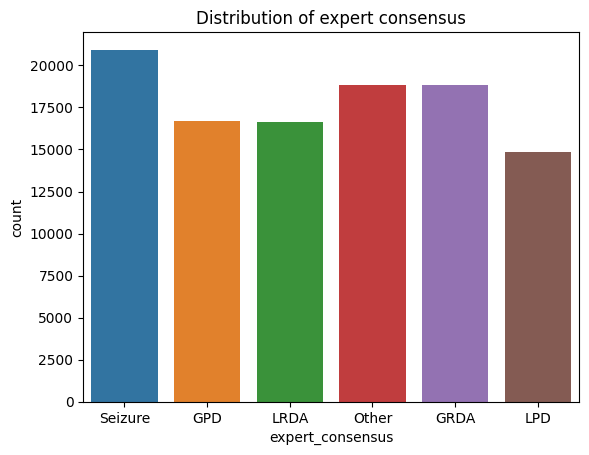

In [18]:
# Plot the distribution of `expert_consensus`
sns.countplot(x='expert_consensus', data=df)
plt.title('Distribution of expert consensus')
plt.show()

## **Apply LabelEncoder**

In [19]:
# Encode the `expert_consensus` column
label_encoder = LabelEncoder()
df['expert_consensus'] = label_encoder.fit_transform(df['expert_consensus'])

In [20]:
# Number of unique patients
num_patients = df['patient_id'].nunique()
print(f"Number of unique patients in train dataset: {num_patients}")

# Number of unique EEG IDs
num_eeg_ids = df['eeg_id'].nunique()
print(f"Number of unique EEG IDs in train dataset: {num_eeg_ids}")

Number of unique patients in train dataset: 1950
Number of unique EEG IDs in train dataset: 17089


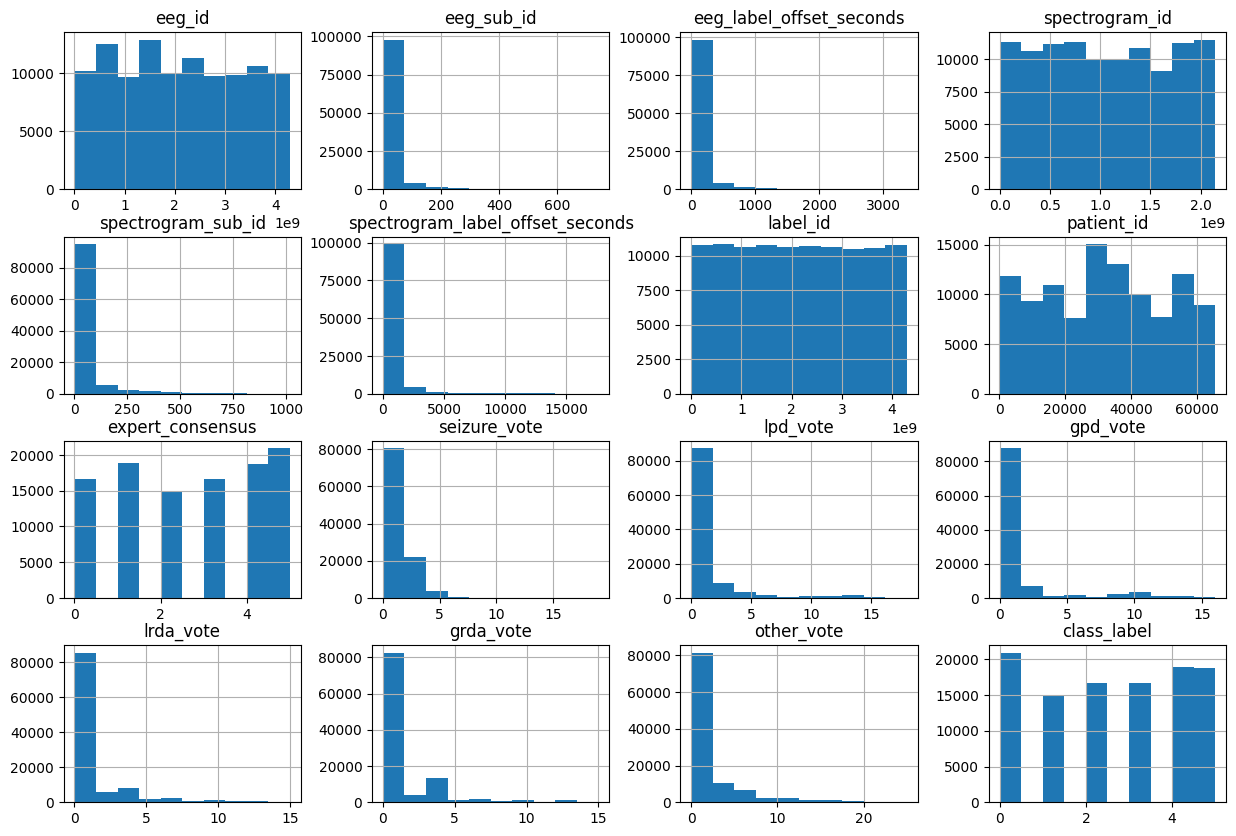

In [21]:
# Histograms for numerical columns
df.hist(figsize=(15, 10))
plt.show()

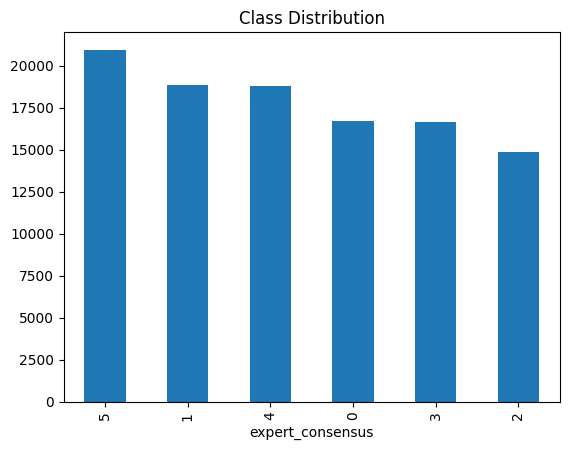

In [22]:
# Class Distribution
df['expert_consensus'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

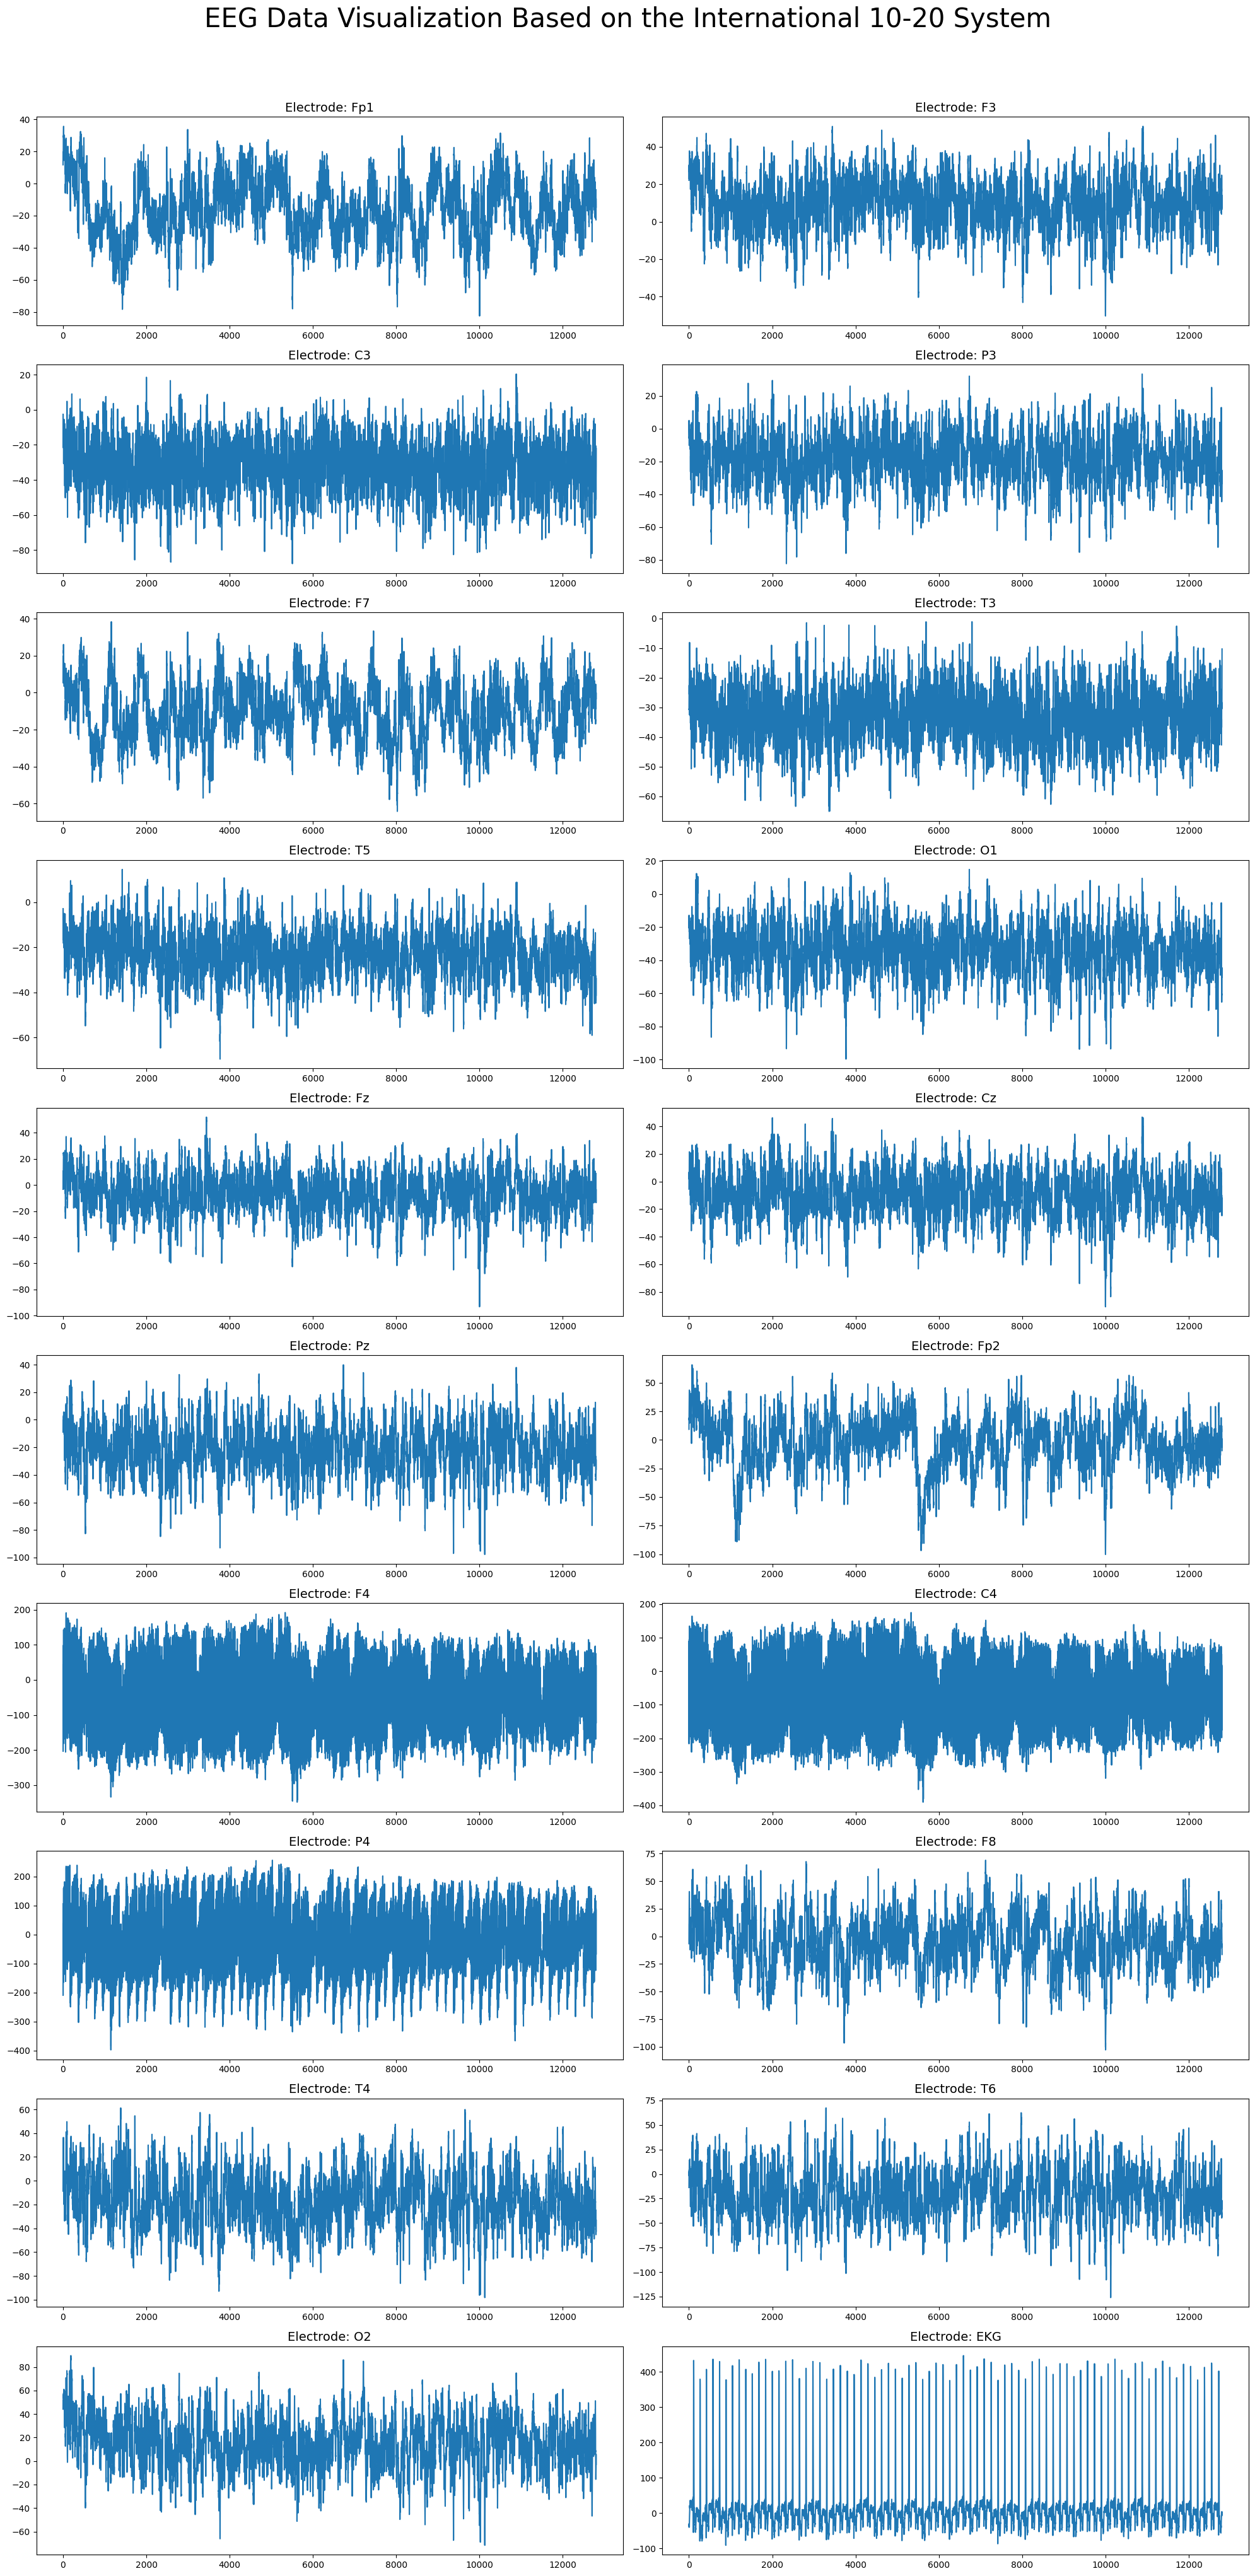

In [23]:
# Load an EEG file
eeg = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1484166292.parquet')
eeg
# List of columns to plot
columns_to_plot = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
# Determine the number of rows/columns needed for subplots
num_plots = len(columns_to_plot)
num_columns = 2  # Set to 2 as per the previous code
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)
# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 4))
# Flatten the axes array for easy iteration
axes = axes.flatten()
# Plot each column in a subplot
for i, col in enumerate(columns_to_plot):
    axes[i].plot(eeg[col])
    axes[i].set_title(f'Electrode: {col}', fontsize=14)
# Hide any unused subplots
for ax in axes[len(columns_to_plot):]:
    ax.set_visible(False)
# Set the overall figure title
fig.suptitle('EEG Data Visualization Based on the International 10-20 System', fontsize=30, y=1.02)
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()

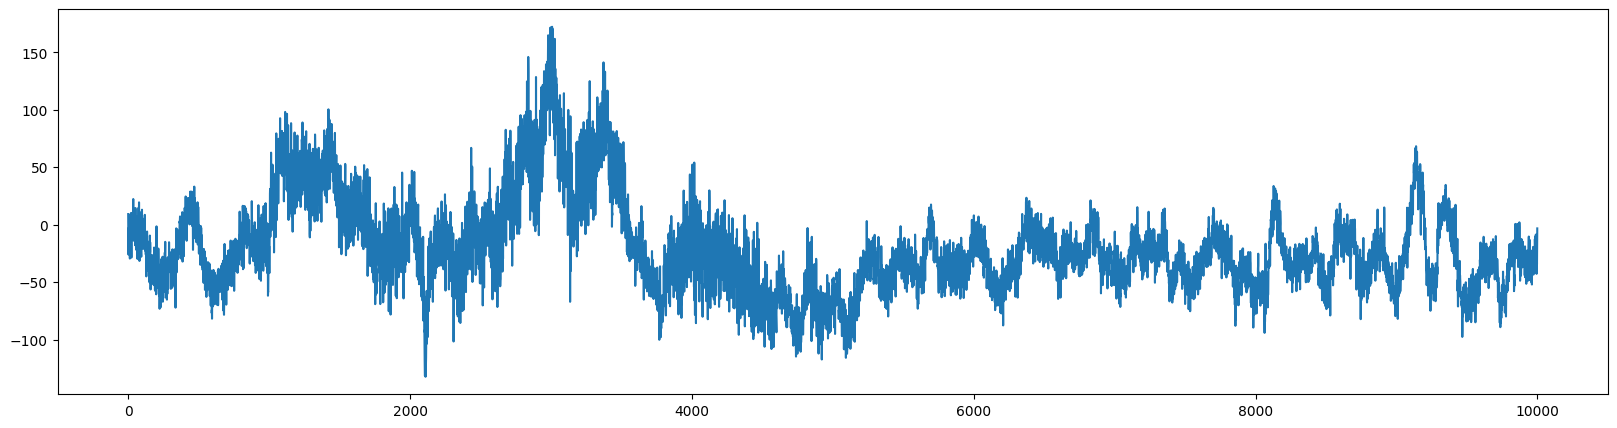

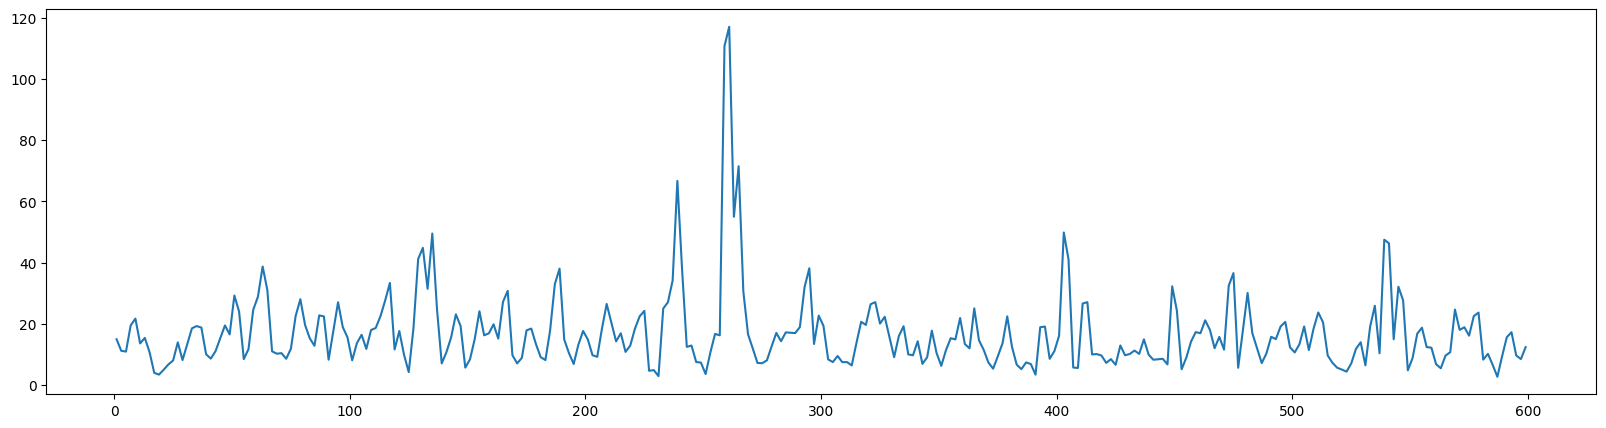

In [24]:
test_egg_id = 3911565283
test_spec_id = 853520

eeg_test = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{test_egg_id}.parquet')    
plt.figure(figsize=(20,5))
plt.plot(eeg_test['Fp1'])

spec_test = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{test_spec_id}.parquet')    
plt.figure(figsize=(20,5))
plt.plot(spec_test['time'], spec_test['LL_0.59'])

## **Load data**

In [25]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment

In [26]:
def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal

In [27]:
def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## **Splitting Data**

In [28]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## **Train and Valid Dataset**

In [29]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


## **Sample Images**

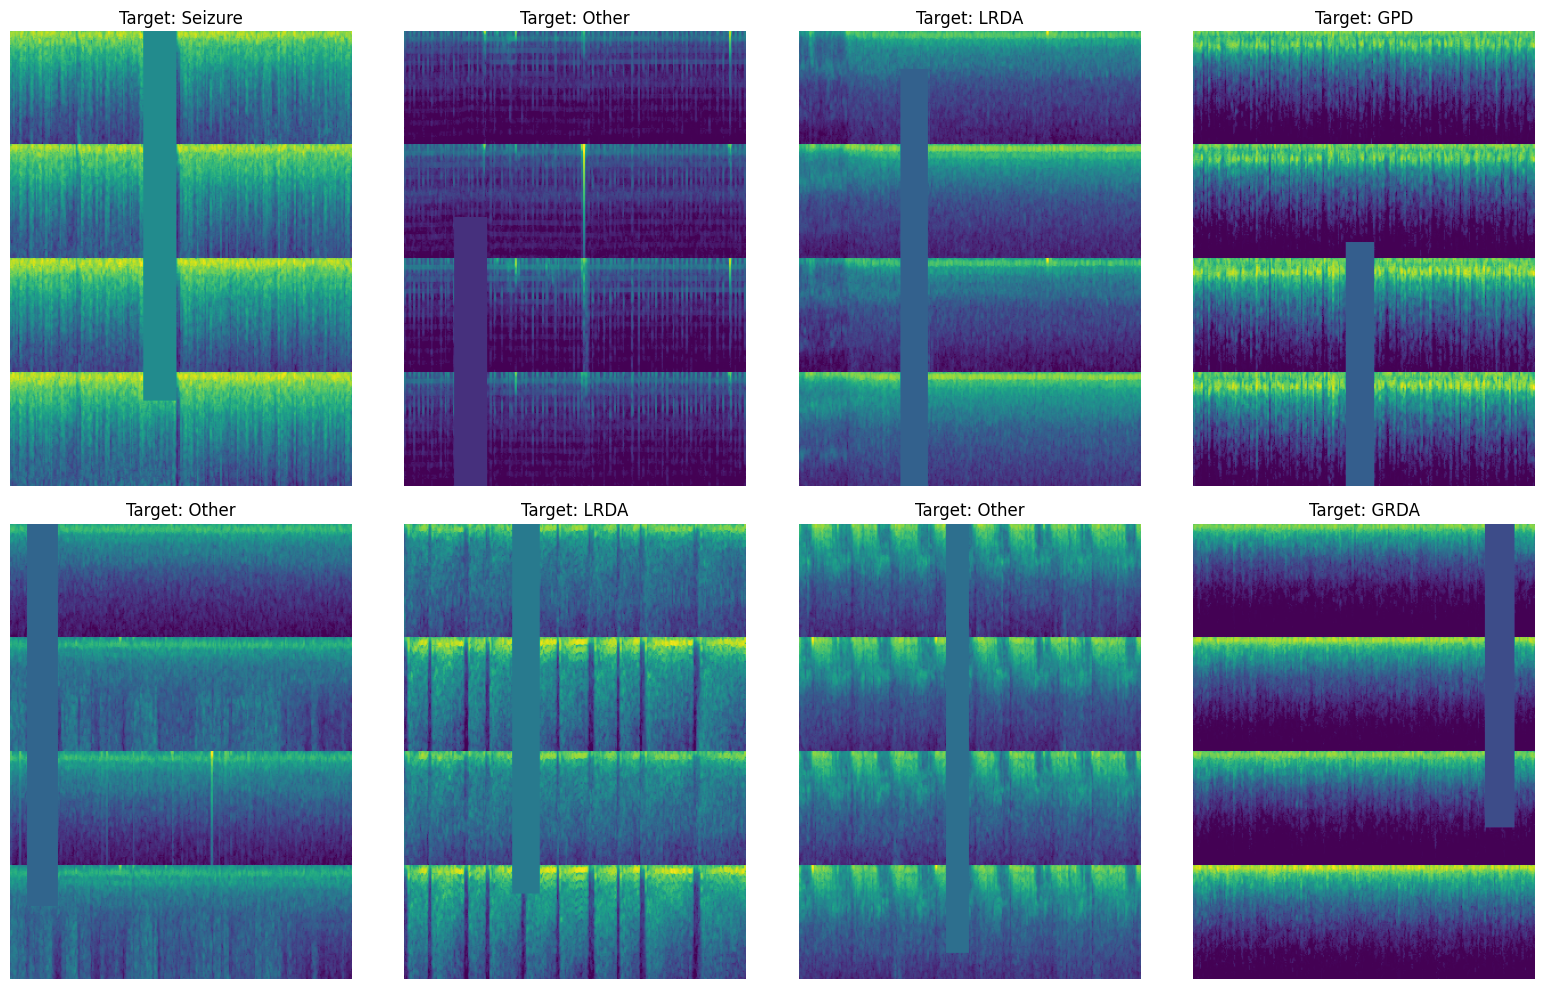

In [30]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## **DenseNet Model**

In [31]:
LOSS = keras.losses.KLDivergence()

In [32]:
import keras_cv

# Build DenseNet model using keras_cv
model = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes
)

# Compile the model  
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,metrics=['accuracy'])

# Model Summary
model.summary()

Attaching 'config.json' from model 'keras/densenet/keras/densenet121_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/densenet/keras/densenet121_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/densenet/keras/densenet121_imagenet/2' to your Kaggle notebook...


Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_net_backbone              │ (None, None, None, 1024)  │  7,037,504 │
│ (DenseNetBackbone)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ avg_pool                        │ (None, 1024)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ predictions (Dense)             │ (None, 6)                 │      6,150 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,960,006 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

## **LR Scheduling**

In [33]:
import math
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

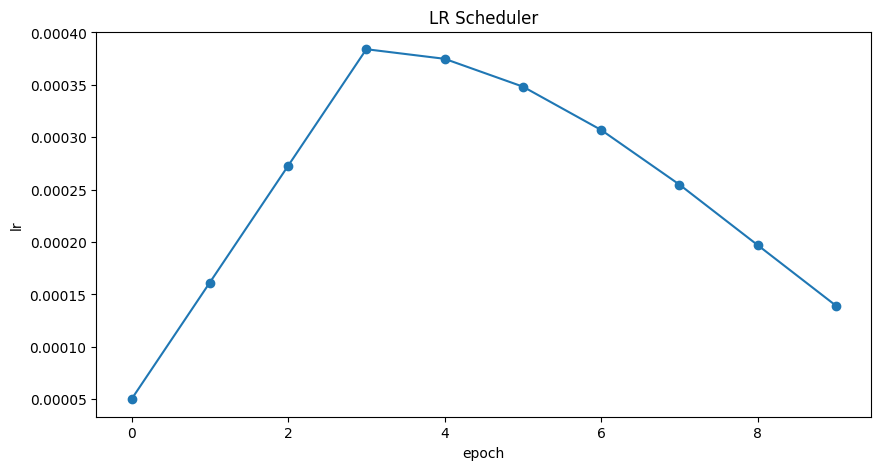

In [34]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

In [35]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [36]:
history = model.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/13


2024-04-08 07:34:17.629237: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,401,301]{3,2,1,0}, f32[64,64,200,150]{3,2,1,0}), window={size=7x7 stride=2x2 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-08 07:34:18.290496: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.661470749s
Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,401,301]{3,2,1,0}, f32[64,64,200,150]{3,2,1,0}), window={size=7x7 stride=2x2 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...


143/143 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.2832 - loss: 1.4657 - val_accuracy: 0.4802 - val_loss: 1.5160 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.5165 - loss: 1.1050 - val_accuracy: 0.4797 - val_loss: 1.6531 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.5939 - loss: 0.9891 - val_accuracy: 0.4838 - val_loss: 1.7227 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6158 - loss: 0.8890 - val_accuracy: 0.3889 - val_loss: 1.7846 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6584 - loss: 0.8311 - val_accuracy: 0.5943 - val_loss: 1.2116 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6784 - loss: 0.7725 - val_accuracy: 0.6405 - val_loss: 1.0101 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.71

## **Prediction**

In [37]:
model.load_weights("best_model.keras")

In [38]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

In [39]:
preds = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [40]:
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

eeg_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0  3911565283      0.014605  0.139291  0.000545   0.515659   0.006316   

   other_vote  
0    0.323583

## **Submission**

In [41]:
# Prepare submission DataFrame (same as before)
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower() + '_vote' for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

# Merge with the sample submission DataFrame (same as before)
sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
# Save the submission DataFrame to a CSV file (same as before)
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

eeg_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0  3911565283      0.014605  0.139291  0.000545   0.515659   0.006316   

   other_vote  
0    0.323583